In [21]:
# DO NOT CHANGE

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# DO NOT CHANGE

#load the model from the pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

with open("./data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

In [33]:
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

def tensor_to_pil(img_tensor):
    # tensor: pre-processed tensor object resulting from preprocess(img).unsqueeze(0)
    unnormed_tensor = unnormalize(img_tensor)
    return transforms.functional.to_pil_image(unnormed_tensor[0])

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

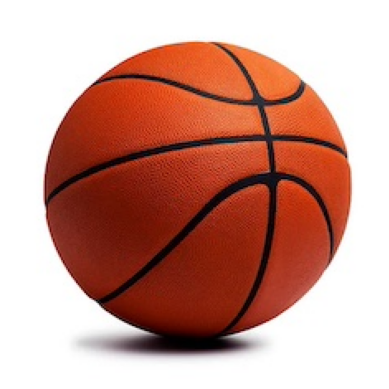

In [34]:
img = Image.open("./data/basketball.jpg")

plt.imshow(img)
plt.axis('off')
plt.show()

In [35]:
change = 1e-3
img_tensor = preprocess(img).unsqueeze(0).to(device)

# Mask
mask = torch.randn_like(img_tensor)*change
mask_parameter = torch.nn.Parameter(mask.to(device))

optimizer = torch.optim.Adam([mask_parameter])
target_index = model(img_tensor).argmax()

with torch.no_grad():
    output = model(img_tensor)

print(f"Image tensor on device:\n---------------\n{img_tensor.device}\n")
print(f"Inputs information:\n---------------\nshape:{img_tensor.shape}\nclass: {type(img_tensor)}\n")
print(f"Shape of outputs:\n---------------\n{output.shape}\n")
print(f"Pred Index:\n---------------\n{output[0].argmax()}\n")
print(f"Pred Label:\n---------------\n{labels[output[0].argmax()]}\n")

Image tensor on device:
---------------
cuda:0

Inputs information:
---------------
shape:torch.Size([1, 3, 224, 224])
class: <class 'torch.Tensor'>

Shape of outputs:
---------------
torch.Size([1, 1000])

Pred Index:
---------------
430

Pred Label:
---------------
basketball



In [36]:
# 512 is the index of 'corkscrew`
target_index = torch.tensor(labels.index('peacock')).unsqueeze(0).to(device)
print("Target index is:\n---------------\n", target_index)

Target index is:
---------------
 tensor([84], device='cuda:0')


In [37]:
def loss(output, mask, target_index, l2_weight):
    classification_loss = torch.nn.functional.cross_entropy(output, target_index)    
    l2_loss = torch.pow(mask, 2).sum()
    total_loss =  classification_loss+(l2_weight * l2_loss)
    return total_loss, classification_loss, l2_loss

In [38]:
import sys

l2_weight = 0.5
step = 0

while True: # evaluate it until the prediction matches the target label
    output = model(img_tensor+mask_parameter)
    total_loss, class_loss, l2_loss = loss(output, mask_parameter, target_index, l2_weight)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    step+=1
    
    sys.stdout.write(f"\rStep: {step}  total loss: {total_loss.item():4.4f}    class loss:{class_loss.item():4.4f}     l2 loss: {l2_loss.item():4.4f}   Predicted class index:{output[0].argmax()}");
    sys.stdout.flush()

    if output[0].argmax().item() == target_index.item():
        break
        
print(f"\n\nWinner winner: {labels[output[0].argmax()]}")

Step: 812  total loss: 3.2595    class loss:1.6787     l2 loss: 3.1615   Predicted class index:840

Winner winner: peacock


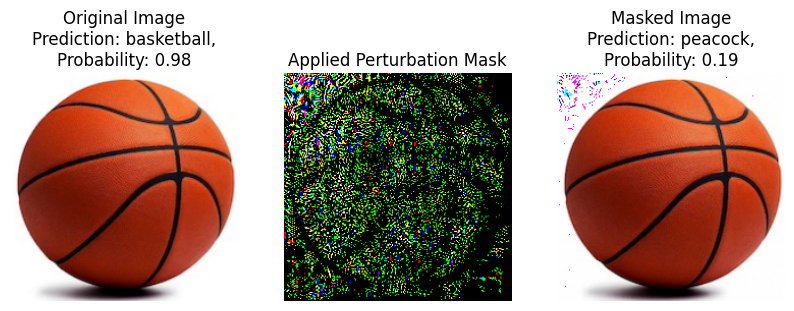

In [39]:
masked_img_tensor = img_tensor + mask_parameter

# get the model prediction and score for the original image and the masked image
with torch.no_grad():
    output = model(img_tensor)
    masked = model(masked_img_tensor)
    
    probs = torch.softmax(output, dim=1)[0][output[0].argmax()].item()
    mask_probs = torch.softmax(masked, dim=1)[0][masked[0].argmax()].item()

    prediction = labels[output[0].argmax()]
    mask_prediction = labels[masked[0].argmax()]

    img_pil = tensor_to_pil(img_tensor)
    masked_pil = tensor_to_pil(masked_img_tensor)
    
plt.figure(figsize=(10, 5))  # Adjust the figsize as needed
plt.subplot(1, 3, 1)
plt.imshow(img_pil)
plt.title(f"Original Image\nPrediction: {prediction},\nProbability: {probs:.2f}")
plt.axis('off')

mask_pil = transforms.functional.to_pil_image(mask_parameter[0])
plt.subplot(1, 3, 2)
plt.imshow(mask_pil)
plt.title(f"Applied Perturbation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(masked_pil)
plt.title(f"Masked Image\nPrediction: {mask_prediction},\nProbability: {mask_probs:.2f}")
plt.axis('off')

plt.show()